# Explore GADME German-FSL Huggingface dataset

1. Log in to Huggingface (if the repository is private)

```bash
huggingface-cli login
```


In [3]:
cache_dir = "/workspace/data"
dataset_name = "default"
dataset_path = "ashraq/esc50"

1. Load dataset

In [5]:
from datasets import load_dataset, DatasetDict

dataset: DatasetDict = load_dataset(name=dataset_name, path=dataset_path, cache_dir=cache_dir) # type: ignore

/root/.cache/pypoetry/virtualenvs/src-xS3fZVNL-py3.10/lib/python3.10/site-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


In [6]:
dataset['train'][0]


{'filename': '1-100032-A-0.wav',
 'fold': 1,
 'target': 0,
 'category': 'dog',
 'esc10': True,
 'src_file': 100032,
 'take': 'A',
 'audio': {'path': None,
  'array': array([0., 0., 0., ..., 0., 0., 0.]),
  'sampling_rate': 44100}}

In [7]:
# get basic statistics

# get number of examples
print('Number of samples: ', len(dataset['train']))

# get number of classes
print('Number of classes: ',len(dataset['train'].unique('category')))

dataset['train'].features

Number of samples:  2000
Number of classes:  50


{'filename': Value(dtype='string', id=None),
 'fold': Value(dtype='int64', id=None),
 'target': Value(dtype='int64', id=None),
 'category': Value(dtype='string', id=None),
 'esc10': Value(dtype='bool', id=None),
 'src_file': Value(dtype='int64', id=None),
 'take': Value(dtype='string', id=None),
 'audio': Audio(sampling_rate=None, mono=True, decode=True, id=None)}

# Load with base_datamodule

<!--  -->

## Waveform

In [8]:
from src.datamodule.base_datamodule import DatasetConfig
from src.datamodule.esc50_datamodule import ESC50Datamodule
dataset_config = DatasetConfig(
    data_dir=cache_dir,
    dataset_name=dataset_name,
    hf_path=dataset_path,
    hf_name="",
    seed=42,
    n_classes=50,
    n_workers=1,
    val_split=0.2,
    task="multiclass",
    subset=None,
    sampling_rate=32000,
)

dm_waveform = ESC50Datamodule(dataset=dataset_config)
dm_waveform.prepare_data()
print(dm_waveform.len_trainset)
print(dm_waveform.num_classes)
dm_waveform.setup(stage='fit')


Saving the dataset (0/2 shards):   0%|          | 0/1600 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/320 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/80 [00:00<?, ? examples/s]

1600
50


In [9]:
dm_waveform.train_dataset[0]

{'input_values': tensor([[0.0098, 0.0129, 0.0114,  ..., 0.0824, 0.0805, 0.0824]]),
 'labels': 19}

In [10]:
# load batch with dataloader and listen to first sample
train_dataloader = dm_waveform.train_dataloader
# get first batch
batch = next(iter(train_dataloader()))
print(batch.keys())
print(batch['input_values'].shape)


dict_keys(['input_values', 'labels'])
torch.Size([32, 1, 160000])


In [11]:
import IPython.display as ipd
waveform = batch['input_values'][15].squeeze().numpy()
ipd.Audio(waveform, rate=32000)

## Spectogram

In [12]:
from src.datamodule.base_datamodule import DatasetConfig
from src.datamodule.components.event_decoding import EventDecoding
from src.datamodule.components.transforms import GADMETransformsWrapper
from src.datamodule.esc50_datamodule import ESC50DataModule
transforms = GADMETransformsWrapper(model_type='vision', decoding=EventDecoding())

dataset_config = DatasetConfig(
    data_dir=cache_dir,
    dataset_name=dataset_name,
    hf_path=dataset_path,
    hf_name="",
    seed=42,
    n_classes=50,
    n_workers=1,
    val_split=0.2,
    task="multiclass",
    subset=None,
    sampling_rate=32000,
)

dm = ESC50DataModule(dataset=dataset_config, transforms=transforms)
dm.prepare_data()
print(dm.len_trainset)
print(dm.num_classes)
dm.setup(stage='fit')


Saving the dataset (0/2 shards):   0%|          | 0/1600 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/320 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/80 [00:00<?, ? examples/s]

1600
50


In [13]:
dm.setup(stage='fit')

dict_keys(['input_values', 'labels'])
torch.Size([32, 1, 128, 1024])


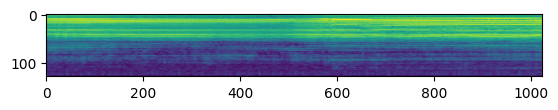

In [14]:
from matplotlib import pyplot as plt
train_dataloader = dm.train_dataloader
# get first batch
batch = next(iter(train_dataloader()))
print(batch.keys())
print(batch['input_values'].shape)
spectorgram = batch['input_values'][0]
plt.imshow(spectorgram.squeeze().numpy())